In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from itertools import combinations

import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.diagnostic as dg
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

from scipy.stats import shapiro
from scipy.stats import mannwhitneyu

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
from matplotlib import pyplot as plt

# MOEX estimation

In [2]:
# IMOEX_test.txt
ms = pd.read_csv('IMOEX_test.txt', sep=",", parse_dates=['<DATE>'])
ms.columns = ["Ticker", "Per", "Date", "Time", "Open", "High", "Low", "Price", "Volume"]
ms

,Ticker,Per,Date,Time,Open,High,Low,Price,Volume
0,IMOEX,D,2021-01-04,0,3304.75,3350.81,3304.17,3350.51,66835524820
1,IMOEX,D,2021-01-05,0,3326.06,3365.32,3301.88,3359.15,71655035538
2,IMOEX,D,2021-01-06,0,3375.91,3380.63,3344.43,3371.03,71374633095
3,IMOEX,D,2021-01-08,0,3399.23,3474.66,3397.15,3454.82,131904843837
4,IMOEX,D,2021-01-11,0,3449.91,3516.90,3436.66,3482.48,143248254278
...,...,...,...,...,...,...,...,...,...
584,IMOEX,D,2023-05-19,0,2627.00,2635.80,2612.47,2626.16,58832351511
585,IMOEX,D,2023-05-22,0,2648.30,2652.59,2622.43,2633.26,47570581512
586,IMOEX,D,2023-05-23,0,2641.05,2647.18,2607.66,2641.66,71916771187
587,IMOEX,D,2023-05-24,0,2643.73,2659.68,2626.58,2654.99,71733180049


In [3]:
ms['Returns_market'] = np.log(ms['Price']) - np.log(ms['Price'].shift(1))

In [4]:
ms["Week"] = 1
for i in range(0,589):
    ms.Week[i] = ms["Date"][i].isocalendar()[1]

ms["Year"] = 1
for i in range(0,589):
    ms.Year[i] = ms["Date"][i].isocalendar()[0]
    
ms["Year_Week"] = 1
for i in range(0,589):
    ms["Year_Week"][i] = str(ms.Year[i])+" "+str(ms.Week[i])

df = pd.DataFrame(ms["Year_Week"].unique()).reset_index()
df.columns = ["week#", "Year_Week"]
ms = pd.merge(ms, df, on=["Year_Week"])

ms

,Ticker,Per,Date,Time,Open,High,Low,Price,Volume,Returns_market,Week,Year,Year_Week,week#
0,IMOEX,D,2021-01-04,0,3304.75,3350.81,3304.17,3350.51,66835524820,NaN,1,2021,2021 1,0
1,IMOEX,D,2021-01-05,0,3326.06,3365.32,3301.88,3359.15,71655035538,0.002575,1,2021,2021 1,0
2,IMOEX,D,2021-01-06,0,3375.91,3380.63,3344.43,3371.03,71374633095,0.003530,1,2021,2021 1,0
3,IMOEX,D,2021-01-08,0,3399.23,3474.66,3397.15,3454.82,131904843837,0.024552,1,2021,2021 1,0
4,IMOEX,D,2021-01-11,0,3449.91,3516.90,3436.66,3482.48,143248254278,0.007974,2,2021,2021 2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
584,IMOEX,D,2023-05-19,0,2627.00,2635.80,2612.47,2626.16,58832351511,-0.002567,20,2023,2023 20,120
585,IMOEX,D,2023-05-22,0,2648.30,2652.59,2622.43,2633.26,47570581512,0.002700,21,2023,2023 21,121
586,IMOEX,D,2023-05-23,0,2641.05,2647.18,2607.66,2641.66,71916771187,0.003185,21,2023,2023 21,121
587,IMOEX,D,2023-05-24,0,2643.73,2659.68,2626.58,2654.99,71733180049,0.005033,21,2023,2023 21,121


In [5]:
ms_weekly_volat = pd.DataFrame(ms.groupby(['week#'])['Returns_market'].std() * np.sqrt(5))  # 5 - trading days in a week
ms_weekly_volat.columns = ["Volat_market"]
ms_weekly_volat["Volat_market"] = ms_weekly_volat["Volat_market"]**2
ms_weekly_volat["week"] = ms_weekly_volat.index
ms_weekly_volat

,Volat_market,week
week#,,
0,0.000771,0
1,0.000300,1
2,0.000467,2
3,0.000502,3
4,0.000431,4
...,...,...
117,0.000167,117
118,0.000799,118
119,0.000867,119


In [6]:
ms.describe()

,Time,Open,High,Low,Price,Volume,Returns_market,Week,Year,week#
count,589.0,589.000000,589.000000,589.000000,589.000000,5.890000e+02,588.000000,589.000000,589.000000,589.000000
mean,0.0,3011.172598,3033.472071,2979.186587,3007.009762,6.966848e+10,-0.000399,24.441426,2021.735144,60.166384
std,0.0,757.165796,756.928320,756.886981,756.260659,4.967372e+10,0.024472,15.137534,0.729228,35.234532
min,0.0,1783.660000,1917.420000,1684.510000,1916.970000,0.000000e+00,-0.404674,1.000000,2021.000000,0.000000
25%,0.0,2251.590000,2269.010000,2225.970000,2248.220000,3.225354e+10,-0.005538,12.000000,2021.000000,30.000000
50%,0.0,2734.430000,2807.470000,2631.150000,2703.510000,6.103728e+10,0.000625,23.000000,2022.000000,60.000000
75%,0.0,3746.760000,3758.580000,3710.250000,3738.680000,9.225113e+10,0.008260,37.000000,2022.000000,91.000000
max,0.0,4286.420000,4292.540000,4259.130000,4287.520000,4.678684e+11,0.182620,52.000000,2023.000000,121.000000


In [7]:
ms["Returns_market"].kurtosis()

132.71295330067724

In [8]:
ms["Returns_market"].skew()

-7.3498904145049355

In [9]:
df1 = pd.DataFrame(ms.groupby(['week#'])['Returns_market'].std()*np.sqrt(5))
df1.columns = ["Volatility"]
df1['Week'] = df1.index
df1

,Volatility,Week
week#,,
0,0.027776,0
1,0.017333,1
2,0.021604,2
3,0.022401,3
4,0.020752,4
...,...,...
117,0.012918,117
118,0.028263,118
119,0.029441,119


In [10]:
df2 = ms.groupby(['week#'])['Volume'].sum()
df2 = pd.DataFrame(df2)
df2['Week'] = df2.index
df2

,Volume,Week
week#,,
0,341770037290,0
1,560438759080,1
2,479620617831,2
3,496982665974,3
4,438708553198,4
...,...,...
117,213219523985,117
118,191898570946,118
119,202983001730,119


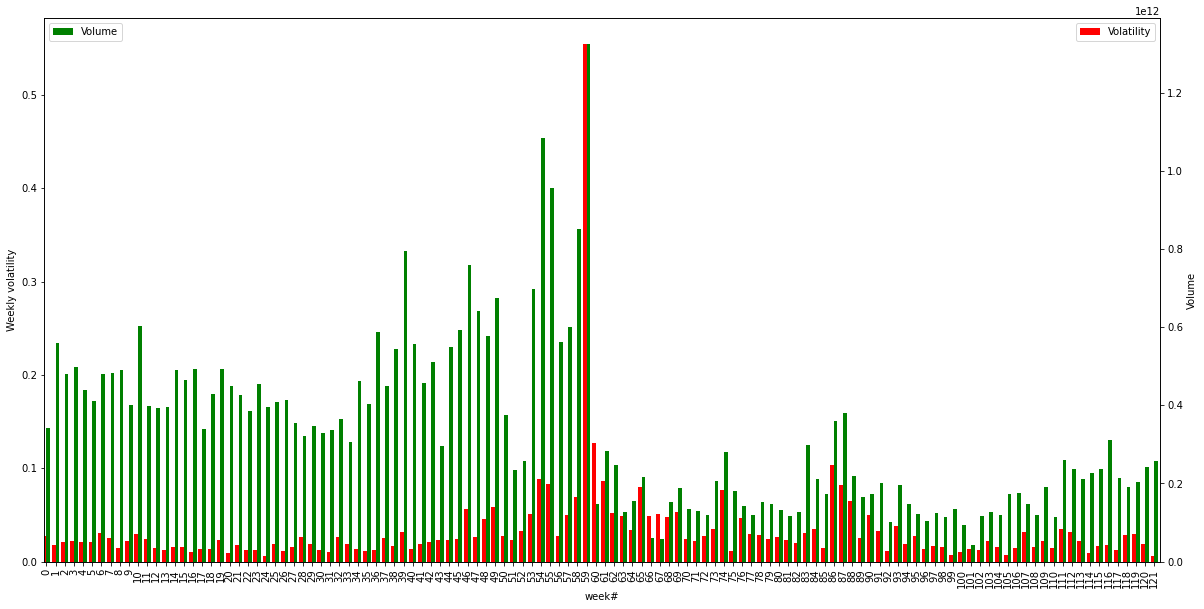

In [11]:
fig = plt.figure(figsize=(20, 10)) # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.4

df1.Volatility.plot(kind='bar', color='red', ax=ax, width=width, position=1, legend=True)
df2.Volume.plot(kind='bar', color='green', ax=ax2, width=width, position=0, legend=True)
plt.legend(loc='upper left')

ax.set_ylabel('Weekly volatility')
ax2.set_ylabel('Volume')

plt.show()

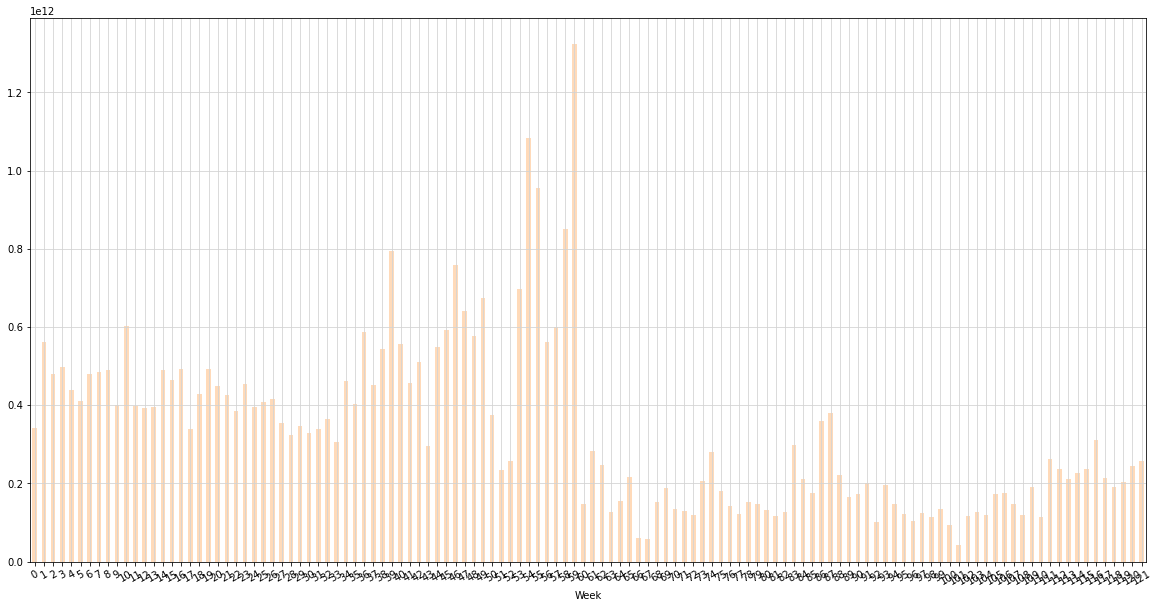

In [12]:
df2.plot.bar(x="Week", y="Volume", color="peachpuff", legend=False, figsize=(20, 10), rot=30)
ax = plt.axes()
ax.set_facecolor("white")
plt.grid(color="lightgrey")
plt.show()


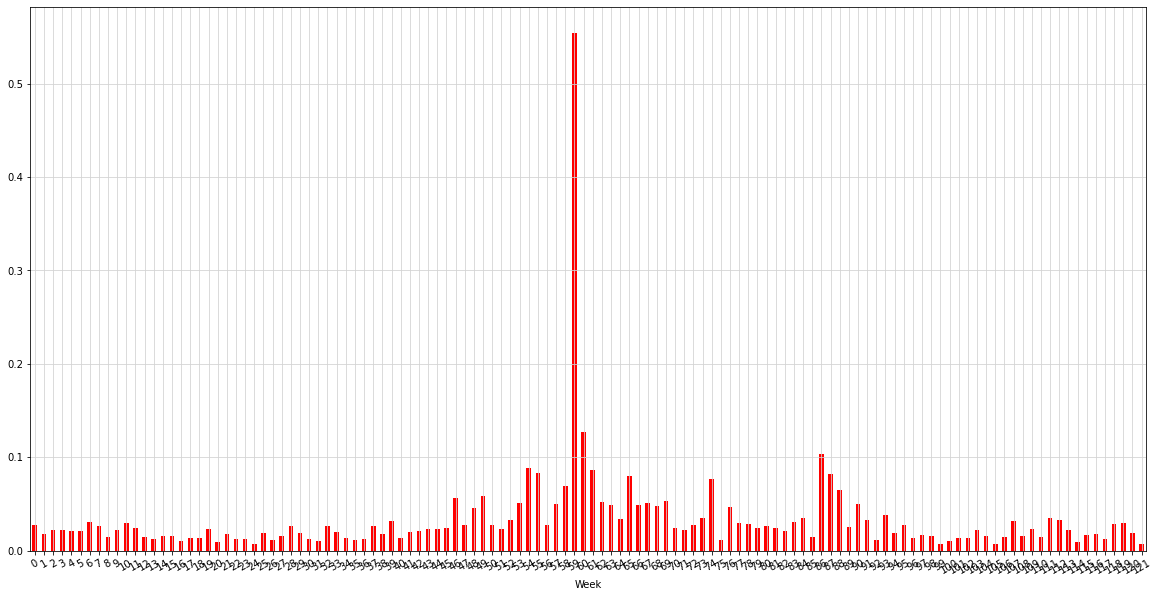

In [13]:
df1.plot.bar(x="Week", y="Volatility", color='red', legend=False, figsize=(20, 10), rot=30)
ax = plt.axes()
ax.set_facecolor("white")
plt.grid(color="lightgrey")
plt.show()

In [14]:
df1.describe()

,Volatility,Week
count,122.000000,122.000000
mean,0.033359,60.500000
std,0.052106,35.362409
min,0.006577,0.000000
25%,0.015097,30.250000
50%,0.022988,60.500000
75%,0.032378,90.750000
max,0.554507,121.000000


In [15]:
df2.describe()

,Volume,Week
count,1.220000e+02,122.000000
mean,3.363503e+11,60.500000
std,2.182306e+11,35.362409
min,4.153948e+10,0.000000
25%,1.566290e+11,30.250000
50%,2.971678e+11,60.500000
75%,4.562446e+11,90.750000
max,1.324284e+12,121.000000


In [16]:
ret = list(ms["Returns_market"].dropna())

name = ['Jarque-Bera', 'P-value', 'Skew', 'Kurtosis']
test = statsmodels.stats.stattools.jarque_bera(ret)
dict(zip(name, test))

{'Jarque-Bera': 429423.07664418843,
 'P-value': 0.0,
 'Skew': -7.331127391854488,
 'Kurtosis': 134.576938711717}

In [17]:
# Shapiro normality test
stat, p = shapiro(ret)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')
    

Statistics=0.552, p=0.000
Sample does not look Gaussian (reject H0)


In [18]:
from scipy.stats import norm,t
t.fit(np.array(ret))
print("Parameters from t.fit: ", t.fit(np.array(ret)), "\n") # degrees of freedom, mean, st dev
norm.fit(np.array(ret))
print("Parameters from norm.fit: ", norm.fit(np.array(ret)), "\n")

Parameters from t.fit:  (2.227786615975221, 0.0010259984386863405, 0.008813774380713759) 

Parameters from norm.fit:  (-0.00039891238138767726, 0.024451603611325333) 



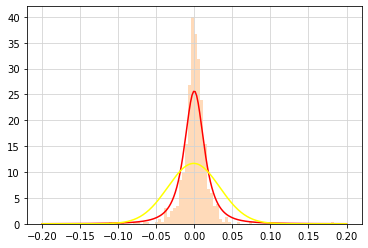

In [19]:
x_min = -0.2
x_max = 0.2
x_t=np.linspace(x_min, x_max, 200)
y_t=t.pdf(x_t, 2.2213992804799556, loc=-9.577289985473442e-05, scale=0.01393038698213338)
x_n=np.linspace(x_min, x_max, 200)
y_n=norm.pdf(x_n, loc=-0.0008321520292537935, scale=0.034166813861123885)
plt.plot(x_t,y_t,c='red')
plt.plot(x_n,y_n,c='yellow')
plt.hist(ret, bins=100, range=(x_min, x_max), density=True, color="peachpuff") #"thistle"
ax = plt.axes()
ax.set_facecolor("white")
plt.grid(color="lightgrey")
plt.show()

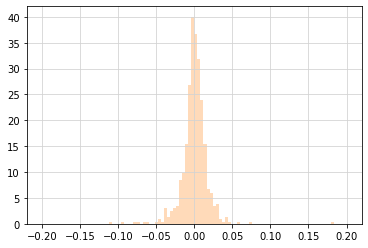

In [20]:
x_min = -0.2
x_max = 0.2
plt.hist(ret, bins=100, range=(x_min, x_max), density=True, color="peachpuff") #"thistle"
ax = plt.axes()
ax.set_facecolor("white")
plt.grid(color="lightgrey")
plt.show()

In [21]:
# IMOEX_1day_2018
dt = pd.read_csv('VTBR_1day_2018.txt', sep=",", parse_dates=['<DATE>'])
dt.columns = ["Ticker", "Per", "Date", "Time", "Open", "High", "Low", "Price", "Volume"]

<AxesSubplot:xlabel='Returns', ylabel='Count'>

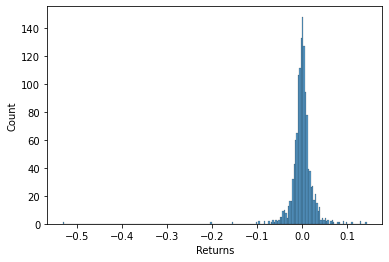

In [22]:
dt["Year"] = 1
for i in range(0,len(dt.Date)):
    dt["Year"][i] = dt["Date"][i].isocalendar()[0]
dt['Returns'] = np.log(dt['Price']) - np.log(dt['Price'].shift(1))
sns.histplot(data=dt, x="Returns")

<AxesSubplot:xlabel='Date', ylabel='Returns'>

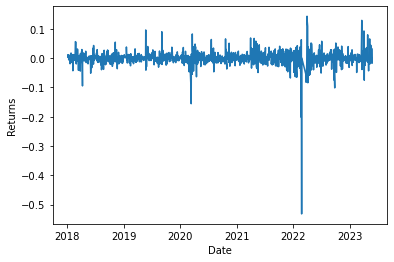

In [23]:
sns.lineplot(data=dt, y="Returns", x="Date")

In [24]:
# IMOEX_data.txt
mss = pd.read_csv('IMOEX_data.txt', sep=",", parse_dates=['<DATE>'])
mss.columns = ["Ticker", "Per", "Date", "Time", "Open", "High", "Low", "Price", "Volume"]
mss

,Ticker,Per,Date,Time,Open,High,Low,Price,Volume
0,RI.IMOEX,15,2021-01-04,101500,3306.12,3322.05,3304.17,3321.87,5484192412
1,RI.IMOEX,15,2021-01-04,103000,3321.92,3325.07,3319.87,3320.18,2708825323
2,RI.IMOEX,15,2021-01-04,104500,3320.05,3324.42,3315.06,3322.96,2249274877
3,RI.IMOEX,15,2021-01-04,110000,3322.75,3327.46,3320.64,3325.27,2298990077
4,RI.IMOEX,15,2021-01-04,111500,3325.05,3326.44,3317.23,3324.24,4116548110
...,...,...,...,...,...,...,...,...,...
20662,RI.IMOEX,15,2023-05-26,180000,2682.42,2685.14,2680.77,2684.08,1928016305
20663,RI.IMOEX,15,2023-05-26,181500,2684.09,2684.95,2681.39,2681.88,1896511654
20664,RI.IMOEX,15,2023-05-26,183000,2681.93,2683.66,2681.69,2682.31,1122605194
20665,RI.IMOEX,15,2023-05-26,184500,2682.29,2682.29,2680.02,2682.04,804995661


In [25]:
mss['Returns_market'] = np.log(mss['Price']) - np.log(mss['Price'].shift(1))

In [26]:
mss["Week"] = 1
for i in range(0,589):
    mss.Week[i] = mss["Date"][i].isocalendar()[1]

mss["Year"] = 1
for i in range(0,589):
    mss.Year[i] = mss["Date"][i].isocalendar()[0]
    
mss["Year_Week"] = 1
for i in range(0,589):
    mss["Year_Week"][i] = str(mss.Year[i])+" "+str(mss.Week[i])

df = pd.DataFrame(mss["Year_Week"].unique()).reset_index()
df.columns = ["week#", "Year_Week"]
mss = pd.merge(mss, df, on=["Year_Week"])

mss

,Ticker,Per,Date,Time,Open,High,Low,Price,Volume,Returns_market,Week,Year,Year_Week,week#
0,RI.IMOEX,15,2021-01-04,101500,3306.12,3322.05,3304.17,3321.87,5484192412,NaN,1,2021,2021 1,0
1,RI.IMOEX,15,2021-01-04,103000,3321.92,3325.07,3319.87,3320.18,2708825323,-0.000509,1,2021,2021 1,0
2,RI.IMOEX,15,2021-01-04,104500,3320.05,3324.42,3315.06,3322.96,2249274877,0.000837,1,2021,2021 1,0
3,RI.IMOEX,15,2021-01-04,110000,3322.75,3327.46,3320.64,3325.27,2298990077,0.000695,1,2021,2021 1,0
4,RI.IMOEX,15,2021-01-04,111500,3325.05,3326.44,3317.23,3324.24,4116548110,-0.000310,1,2021,2021 1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20662,RI.IMOEX,15,2023-05-26,180000,2682.42,2685.14,2680.77,2684.08,1928016305,0.000626,1,1,1,4
20663,RI.IMOEX,15,2023-05-26,181500,2684.09,2684.95,2681.39,2681.88,1896511654,-0.000820,1,1,1,4
20664,RI.IMOEX,15,2023-05-26,183000,2681.93,2683.66,2681.69,2682.31,1122605194,0.000160,1,1,1,4
20665,RI.IMOEX,15,2023-05-26,184500,2682.29,2682.29,2680.02,2682.04,804995661,-0.000101,1,1,1,4


In [27]:
params_ms = [["Ticker", "Date", "Daily_ret", "Intraday_volat", "#_15min", "Daily_volat"]]
for date in mss["Date"].unique():
    temp = mss.loc[mss["Date"] == date]
    ret = np.sum(temp["Returns_market"])
    count = len(temp.Date)
    if len(temp.Date) > 1:
        volat = temp["Returns_market"].std()
        volat_daily = volat * np.sqrt(count)
    params_ms.append(["MOEX", date, ret, volat, count, volat_daily])
    
ms_param = pd.DataFrame(params_ms[1:], columns = params_ms[0])
ms_param

,Ticker,Date,Daily_ret,Intraday_volat,#_15min,Daily_volat
0,MOEX,2021-01-04,0.008585,0.000747,36,0.004480
1,MOEX,2021-01-05,0.002575,0.002290,36,0.013740
2,MOEX,2021-01-06,0.003530,0.001252,36,0.007512
3,MOEX,2021-01-08,0.027817,0.002328,30,0.012749
4,MOEX,2021-01-11,0.004528,0.002856,26,0.014562
...,...,...,...,...,...,...
585,MOEX,2023-05-22,0.002700,0.001575,36,0.009449
586,MOEX,2023-05-23,0.003185,0.001587,36,0.009523
587,MOEX,2023-05-24,0.005033,0.001169,36,0.007016
588,MOEX,2023-05-25,-0.001889,0.001131,36,0.006783


In [28]:
ms_param["Week"] = 1
for i in range(0,590):
    ms_param.Week[i] = ms_param["Date"][i].isocalendar()[1]

ms_param["Year"] = 1
for i in range(0,590):
    ms_param.Year[i] = ms_param["Date"][i].isocalendar()[0]
    
ms_param["Year_Week"] = 1
for i in range(0,590):
    ms_param["Year_Week"][i] = str(ms_param.Year[i])+" "+str(ms_param.Week[i])

df = pd.DataFrame(ms_param["Year_Week"].unique()).reset_index()
df.columns = ["week#", "Year_Week"]
ms_param = pd.merge(ms_param, df, on=["Year_Week"])

ms_param


,Ticker,Date,Daily_ret,Intraday_volat,#_15min,Daily_volat,Week,Year,Year_Week,week#
0,MOEX,2021-01-04,0.008585,0.000747,36,0.004480,1,2021,2021 1,0
1,MOEX,2021-01-05,0.002575,0.002290,36,0.013740,1,2021,2021 1,0
2,MOEX,2021-01-06,0.003530,0.001252,36,0.007512,1,2021,2021 1,0
3,MOEX,2021-01-08,0.027817,0.002328,30,0.012749,1,2021,2021 1,0
4,MOEX,2021-01-11,0.004528,0.002856,26,0.014562,2,2021,2021 2,1
...,...,...,...,...,...,...,...,...,...,...
585,MOEX,2023-05-22,0.002700,0.001575,36,0.009449,21,2023,2023 21,121
586,MOEX,2023-05-23,0.003185,0.001587,36,0.009523,21,2023,2023 21,121
587,MOEX,2023-05-24,0.005033,0.001169,36,0.007016,21,2023,2023 21,121
588,MOEX,2023-05-25,-0.001889,0.001131,36,0.006783,21,2023,2023 21,121


In [29]:
# выходные дни удалить? - удаляем
ms_param = ms_param.loc[ms_param["#_15min"]!=1]

In [30]:
df_ms = pd.DataFrame(ms_param.groupby(['week#'])['Daily_ret'].std()*np.sqrt(5))

df_ms.columns = ["Weekly_volat"] #["Weekly_volat", "week#_df"]

ms_param = pd.merge(ms_param, df_ms, on=["week#"])

In [31]:
ms_param

,Ticker,Date,Daily_ret,Intraday_volat,#_15min,Daily_volat,Week,Year,Year_Week,week#,Weekly_volat
0,MOEX,2021-01-04,0.008585,0.000747,36,0.004480,1,2021,2021 1,0,0.026296
1,MOEX,2021-01-05,0.002575,0.002290,36,0.013740,1,2021,2021 1,0,0.026296
2,MOEX,2021-01-06,0.003530,0.001252,36,0.007512,1,2021,2021 1,0,0.026296
3,MOEX,2021-01-08,0.027817,0.002328,30,0.012749,1,2021,2021 1,0,0.026296
4,MOEX,2021-01-11,0.004528,0.002856,26,0.014562,2,2021,2021 2,1,0.017351
...,...,...,...,...,...,...,...,...,...,...,...
585,MOEX,2023-05-22,0.002700,0.001575,36,0.009449,21,2023,2023 21,121,0.011304
586,MOEX,2023-05-23,0.003185,0.001587,36,0.009523,21,2023,2023 21,121,0.011304
587,MOEX,2023-05-24,0.005033,0.001169,36,0.007016,21,2023,2023 21,121,0.011304
588,MOEX,2023-05-25,-0.001889,0.001131,36,0.006783,21,2023,2023 21,121,0.011304


In [32]:
# t distribution degrees of freedom estimated earlier
ms_param["df_t"] = 2.227786615975221

In [33]:
ms_param

,Ticker,Date,Daily_ret,Intraday_volat,#_15min,Daily_volat,Week,Year,Year_Week,week#,Weekly_volat,df_t
0,MOEX,2021-01-04,0.008585,0.000747,36,0.004480,1,2021,2021 1,0,0.026296,2.227787
1,MOEX,2021-01-05,0.002575,0.002290,36,0.013740,1,2021,2021 1,0,0.026296,2.227787
2,MOEX,2021-01-06,0.003530,0.001252,36,0.007512,1,2021,2021 1,0,0.026296,2.227787
3,MOEX,2021-01-08,0.027817,0.002328,30,0.012749,1,2021,2021 1,0,0.026296,2.227787
4,MOEX,2021-01-11,0.004528,0.002856,26,0.014562,2,2021,2021 2,1,0.017351,2.227787
...,...,...,...,...,...,...,...,...,...,...,...,...
585,MOEX,2023-05-22,0.002700,0.001575,36,0.009449,21,2023,2023 21,121,0.011304,2.227787
586,MOEX,2023-05-23,0.003185,0.001587,36,0.009523,21,2023,2023 21,121,0.011304,2.227787
587,MOEX,2023-05-24,0.005033,0.001169,36,0.007016,21,2023,2023 21,121,0.011304,2.227787
588,MOEX,2023-05-25,-0.001889,0.001131,36,0.006783,21,2023,2023 21,121,0.011304,2.227787


### Risk-free MOSPRIME

In [34]:
rf = pd.read_excel('mosprime.xlsx', parse_dates=['Date'])
rf["1M"].replace('--', np.NaN, inplace=True)
rf["1M"].astype(float)
rf.dropna(subset=['1M'], inplace=True)
rf = rf.sort_values(by=['Date'])

In [35]:
rf["Returns_rf"] = np.log(1+rf['1M']/100)/252 #adjust to the daily return

In [36]:
rf

,Date,ON,1W,2W,1M,2M,3M,6M,Returns_rf
611,2020-12-01,4.43,4.50,4.52,4.70,4.82,4.95,4.89,0.000182
610,2020-12-02,4.42,4.50,4.52,4.73,4.82,4.96,4.88,0.000183
609,2020-12-03,4.38,4.48,4.51,4.73,4.81,4.96,4.88,0.000183
608,2020-12-04,4.35,4.46,4.51,4.74,4.80,4.97,4.89,0.000184
607,2020-12-07,4.14,4.44,4.50,4.74,4.80,4.97,4.90,0.000184
...,...,...,...,...,...,...,...,...,...
4,2023-05-23,7.44,7.63,7.69,7.85,8.09,8.34,8.54,0.000300
3,2023-05-24,7.48,7.65,7.72,7.87,8.10,8.33,8.51,0.000301
2,2023-05-25,7.45,7.62,7.70,7.87,8.10,8.33,8.51,0.000301
1,2023-05-26,7.48,7.65,7.72,7.87,8.10,8.33,8.51,0.000301


### Add rf in the tables

In [37]:
ms_param = pd.merge(ms_param, rf[['Date','Returns_rf']], left_on='Date', right_on='Date', how='left')

In [38]:
ms_param.fillna(method='bfill', inplace=True)
ms_param

,Ticker,Date,Daily_ret,Intraday_volat,#_15min,Daily_volat,Week,Year,Year_Week,week#,Weekly_volat,df_t,Returns_rf
0,MOEX,2021-01-04,0.008585,0.000747,36,0.004480,1,2021,2021 1,0,0.026296,2.227787,0.000183
1,MOEX,2021-01-05,0.002575,0.002290,36,0.013740,1,2021,2021 1,0,0.026296,2.227787,0.000183
2,MOEX,2021-01-06,0.003530,0.001252,36,0.007512,1,2021,2021 1,0,0.026296,2.227787,0.000183
3,MOEX,2021-01-08,0.027817,0.002328,30,0.012749,1,2021,2021 1,0,0.026296,2.227787,0.000183
4,MOEX,2021-01-11,0.004528,0.002856,26,0.014562,2,2021,2021 2,1,0.017351,2.227787,0.000183
...,...,...,...,...,...,...,...,...,...,...,...,...,...
585,MOEX,2023-05-22,0.002700,0.001575,36,0.009449,21,2023,2023 21,121,0.011304,2.227787,0.000301
586,MOEX,2023-05-23,0.003185,0.001587,36,0.009523,21,2023,2023 21,121,0.011304,2.227787,0.000300
587,MOEX,2023-05-24,0.005033,0.001169,36,0.007016,21,2023,2023 21,121,0.011304,2.227787,0.000301
588,MOEX,2023-05-25,-0.001889,0.001131,36,0.006783,21,2023,2023 21,121,0.011304,2.227787,0.000301


In [39]:
from scipy.stats import norm,t
ms_param["Proba_loss"] = 1
length = len(ms_param["Date"])+1
for i in range(0, 588): #len(sb_param["Date"])+1
    ms_param["Proba_loss"].iloc[i] = t.cdf(ms_param["Returns_rf"].iloc[i], ms_param["df_t"].iloc[i], loc=ms_param["Daily_ret"].iloc[i], scale=ms_param["Daily_volat"].iloc[i])
ms_param

,Ticker,Date,Daily_ret,Intraday_volat,#_15min,Daily_volat,Week,Year,Year_Week,week#,Weekly_volat,df_t,Returns_rf,Proba_loss
0,MOEX,2021-01-04,0.008585,0.000747,36,0.004480,1,2021,2021 1,0,0.026296,2.227787,0.000183,0.094222
1,MOEX,2021-01-05,0.002575,0.002290,36,0.013740,1,2021,2021 1,0,0.026296,2.227787,0.000183,0.438175
2,MOEX,2021-01-06,0.003530,0.001252,36,0.007512,1,2021,2021 1,0,0.026296,2.227787,0.000183,0.347759
3,MOEX,2021-01-08,0.027817,0.002328,30,0.012749,1,2021,2021 1,0,0.026296,2.227787,0.000183,0.074679
4,MOEX,2021-01-11,0.004528,0.002856,26,0.014562,2,2021,2021 2,1,0.017351,2.227787,0.000183,0.395497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585,MOEX,2023-05-22,0.002700,0.001575,36,0.009449,21,2023,2023 21,121,0.011304,2.227787,0.000301,0.410549
586,MOEX,2023-05-23,0.003185,0.001587,36,0.009523,21,2023,2023 21,121,0.011304,2.227787,0.000300,0.393960
587,MOEX,2023-05-24,0.005033,0.001169,36,0.007016,21,2023,2023 21,121,0.011304,2.227787,0.000301,0.281606
588,MOEX,2023-05-25,-0.001889,0.001131,36,0.006783,21,2023,2023 21,121,0.011304,2.227787,0.000301,1.000000


In [40]:
ms_param["Proba_loss"].mean()

0.4835966990182753

In [41]:
ms_proba_loss = pd.DataFrame(ms_param.groupby(['week#'])['Proba_loss'].std())
ms_proba_loss["Ambiguity"] = 4*ms_proba_loss['Proba_loss']**2
ms_proba_loss

,Proba_loss,Ambiguity
week#,,
0,0.182081,0.132614
1,0.212812,0.181156
2,0.259314,0.268976
3,0.194163,0.150798
4,0.196997,0.155231
...,...,...
117,0.252274,0.254569
118,0.264876,0.280638
119,0.293270,0.344029


In [42]:
ms_proba_loss.describe(())

,Proba_loss,Ambiguity
count,122.000000,122.000000
mean,0.255912,0.278153
std,0.063883,0.122881
min,0.063907,0.016336
50%,0.269822,0.291232
max,0.372924,0.556289


<AxesSubplot:xlabel='Ambiguity', ylabel='Count'>

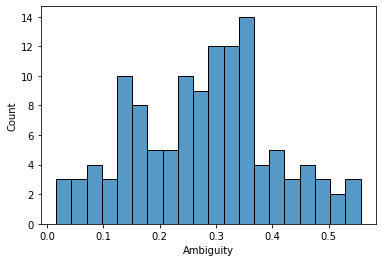

In [43]:
sns.histplot(data=ms_proba_loss, x="Ambiguity", bins = 20)

<AxesSubplot:xlabel='week#', ylabel='Ambiguity'>

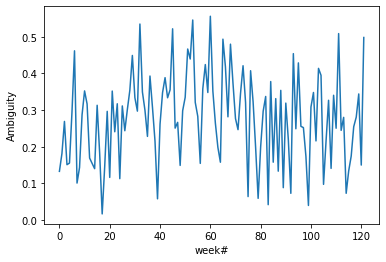

In [44]:
sns.lineplot(data=ms_proba_loss, y="Ambiguity", x="week#")

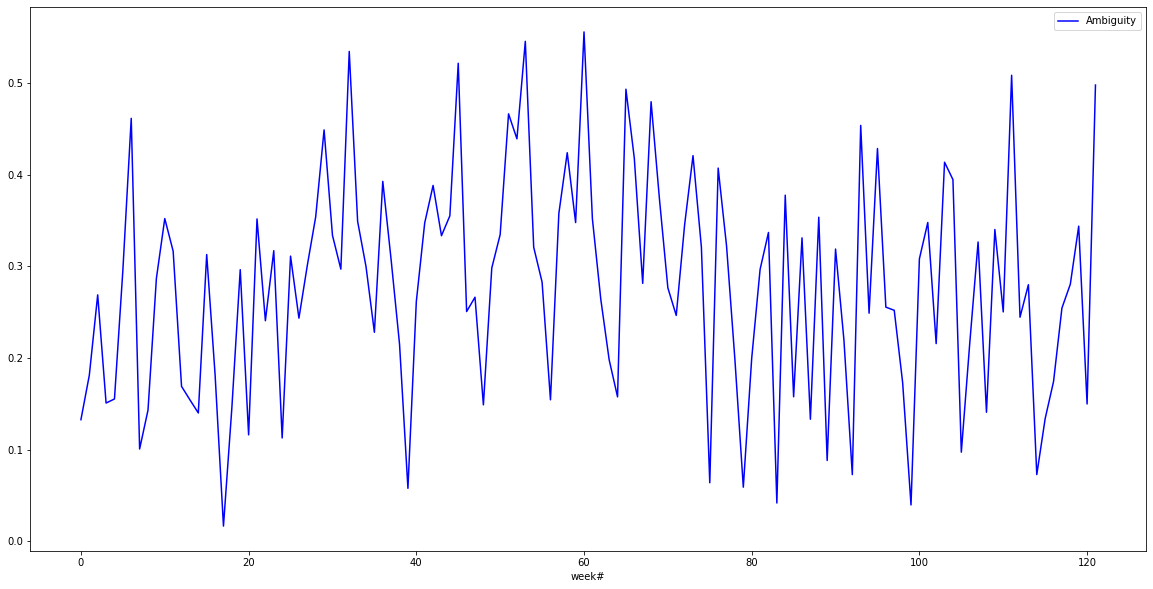

In [45]:
fig = plt.figure(figsize=(20, 10)) # Create matplotlib figure


ms_proba_loss.Ambiguity.plot(kind='line', color='blue', legend=True)

plt.show()

In [46]:
ms_param

,Ticker,Date,Daily_ret,Intraday_volat,#_15min,Daily_volat,Week,Year,Year_Week,week#,Weekly_volat,df_t,Returns_rf,Proba_loss
0,MOEX,2021-01-04,0.008585,0.000747,36,0.004480,1,2021,2021 1,0,0.026296,2.227787,0.000183,0.094222
1,MOEX,2021-01-05,0.002575,0.002290,36,0.013740,1,2021,2021 1,0,0.026296,2.227787,0.000183,0.438175
2,MOEX,2021-01-06,0.003530,0.001252,36,0.007512,1,2021,2021 1,0,0.026296,2.227787,0.000183,0.347759
3,MOEX,2021-01-08,0.027817,0.002328,30,0.012749,1,2021,2021 1,0,0.026296,2.227787,0.000183,0.074679
4,MOEX,2021-01-11,0.004528,0.002856,26,0.014562,2,2021,2021 2,1,0.017351,2.227787,0.000183,0.395497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585,MOEX,2023-05-22,0.002700,0.001575,36,0.009449,21,2023,2023 21,121,0.011304,2.227787,0.000301,0.410549
586,MOEX,2023-05-23,0.003185,0.001587,36,0.009523,21,2023,2023 21,121,0.011304,2.227787,0.000300,0.393960
587,MOEX,2023-05-24,0.005033,0.001169,36,0.007016,21,2023,2023 21,121,0.011304,2.227787,0.000301,0.281606
588,MOEX,2023-05-25,-0.001889,0.001131,36,0.006783,21,2023,2023 21,121,0.011304,2.227787,0.000301,1.000000


## Estimation

In [47]:
# ms_weekly_volat

In [48]:
ms_ret = pd.DataFrame(ms_param.groupby(['week#']).aggregate({'Daily_ret': 'sum', 'Returns_rf': 'sum'}))
ms_ret.columns = ["Weekly_ret", "Weekly_ret_rf"]
ms_ret["Premium"] = ms_ret['Weekly_ret'] - ms_ret['Weekly_ret_rf']
ms_ret["week"] = ms_ret.index
ms_proba_loss["week"] = ms_proba_loss.index

In [49]:
ms_final = pd.merge(ms_ret[['week', 'Premium']], ms_proba_loss[['week', 'Ambiguity']], left_on='week', right_on='week', how='left')
ms_final = pd.merge(ms_final, ms_weekly_volat, left_on='week', right_on='week', how='left')
ms_final["Ambiguity_1"] = ms_final["Ambiguity"].shift(1)
ms_final["Ambiguity_2"] = ms_final["Ambiguity"].shift(2)
ms_final["Ambiguity_3"] = ms_final["Ambiguity"].shift(3)
ms_final["Volat_market_1"] = ms_final["Volat_market"].shift(1)
ms_final["Volat_market_2"] = ms_final["Volat_market"].shift(2)
ms_final["Volat_market_3"] = ms_final["Volat_market"].shift(3)
ms_final

,week,Premium,Ambiguity,Volat_market,Ambiguity_1,Ambiguity_2,Ambiguity_3,Volat_market_1,Volat_market_2,Volat_market_3
0,0,0.041774,0.132614,0.000771,NaN,NaN,NaN,NaN,NaN,NaN
1,1,-0.004353,0.181156,0.000300,0.132614,NaN,NaN,0.000771,NaN,NaN
2,2,-0.018705,0.268976,0.000467,0.181156,0.132614,NaN,0.000300,0.000771,NaN
3,3,-0.035983,0.150798,0.000502,0.268976,0.181156,0.132614,0.000467,0.000300,0.000771
4,4,0.033991,0.155231,0.000431,0.150798,0.268976,0.181156,0.000502,0.000467,0.000300
...,...,...,...,...,...,...,...,...,...,...
117,117,-0.003406,0.254569,0.000167,0.174326,0.133788,0.072632,0.000316,0.000281,0.000086
118,118,-0.038592,0.280638,0.000799,0.254569,0.174326,0.133788,0.000167,0.000316,0.000281
119,119,0.009348,0.344029,0.000867,0.280638,0.254569,0.174326,0.000799,0.000167,0.000316
120,120,0.021994,0.149764,0.000357,0.344029,0.280638,0.254569,0.000867,0.000799,0.000167


In [50]:
def get_ols(X):
    '''Function for getting OLS Regression model with intercept'''
    x = sm.add_constant(X)
    model = sm.OLS(y, x).fit()
    return model

In [89]:
y = ms_final.Premium[1:]
x = ms_final[['Ambiguity', 'Volat_market']][1:]
model1_ms = get_ols(x)
model1_ms.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Premium   R-squared:                       0.430
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                     44.56
Date:                Fri, 09 Jun 2023   Prob (F-statistic):           3.83e-15
Time:                        12:13:18   Log-Likelihood:                 238.32
No. Observations:                 121   AIC:                            -470.6
Df Residuals:                     118   BIC:                            -462.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0009      0.008      0.121      0.904      -0.014       0.016
Ambiguity       -0.0019      0.026     -0.074      0.941      -0.052       0.049
Volat_market    -1.0543      0.112     -9.408      0.000      -1.276      -0.832
==============================================================================
Omnibus:                       18.439   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               48.530
Skew:                          -0.500   Prob(JB):                     2.90e-11
Kurtosis:                       5.937   Cond. No.                         37.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [90]:
y = ms_final.Premium[1:]
x = ms_final[['Ambiguity_1', 'Volat_market']][1:]
model2_ms = get_ols(x)
model2_ms.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Premium   R-squared:                       0.432
Model:                            OLS   Adj. R-squared:                  0.423
Method:                 Least Squares   F-statistic:                     44.90
Date:                Fri, 09 Jun 2023   Prob (F-statistic):           3.16e-15
Time:                        12:13:18   Log-Likelihood:                 238.51
No. Observations:                 121   AIC:                            -471.0
Df Residuals:                     118   BIC:                            -462.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0048      0.008      0.623      0.535      -0.011       0.020
Ambiguity_1     -0.0161      0.026     -0.622      0.535      -0.067       0.035
Volat_market    -1.0462      0.112     -9.304      0.000      -1.269      -0.824
==============================================================================
Omnibus:                       19.586   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.275
Skew:                          -0.498   Prob(JB):                     3.66e-13
Kurtosis:                       6.220   Cond. No.                         37.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [91]:
y = ms_final.Premium[2:]
x = ms_final[['Ambiguity_2', 'Volat_market']][2:]
model3_ms= get_ols(x)
model3_ms.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Premium   R-squared:                       0.433
Model:                            OLS   Adj. R-squared:                  0.423
Method:                 Least Squares   F-statistic:                     44.61
Date:                Fri, 09 Jun 2023   Prob (F-statistic):           3.98e-15
Time:                        12:13:18   Log-Likelihood:                 236.10
No. Observations:                 120   AIC:                            -466.2
Df Residuals:                     117   BIC:                            -457.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0054      0.008      0.688      0.493      -0.010       0.021
Ambiguity_2     -0.0178      0.026     -0.689      0.492      -0.069       0.033
Volat_market    -1.0490      0.112     -9.337      0.000      -1.271      -0.826
==============================================================================
Omnibus:                       16.729   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.432
Skew:                          -0.451   Prob(JB):                     6.11e-10
Kurtosis:                       5.770   Cond. No.                         37.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [92]:
y = ms_final.Premium[3:]
x = ms_final[['Ambiguity_3', 'Volat_market']][3:]
model4_ms = get_ols(x)
model4_ms.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Premium   R-squared:                       0.434
Model:                            OLS   Adj. R-squared:                  0.424
Method:                 Least Squares   F-statistic:                     44.40
Date:                Fri, 09 Jun 2023   Prob (F-statistic):           4.80e-15
Time:                        12:13:18   Log-Likelihood:                 233.79
No. Observations:                 119   AIC:                            -461.6
Df Residuals:                     116   BIC:                            -453.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0056      0.008      0.708      0.480      -0.010       0.021
Ambiguity_3     -0.0179      0.026     -0.689      0.492      -0.069       0.034
Volat_market    -1.0622      0.113     -9.423      0.000      -1.285      -0.839
==============================================================================
Omnibus:                       19.693   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               55.874
Skew:                          -0.522   Prob(JB):                     7.36e-13
Kurtosis:                       6.190   Cond. No.                         37.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [93]:
y = ms_final.Premium[3:]
x = ms_final[['Ambiguity', 'Ambiguity_1', 'Ambiguity_2', 'Ambiguity_3', 'Volat_market', 'Volat_market_1', 'Volat_market_2', 'Volat_market_3']][3:]
model5_ms = get_ols(x)
model5_ms.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Premium   R-squared:                       0.511
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     14.37
Date:                Fri, 09 Jun 2023   Prob (F-statistic):           3.51e-14
Time:                        12:13:18   Log-Likelihood:                 242.54
No. Observations:                 119   AIC:                            -467.1
Df Residuals:                     110   BIC:                            -442.1
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0195      0.013      1.491      0.139      -0.006       0.045
Ambiguity         -0.0079      0.025     -0.313      0.755      -0.058       0.042
Ambiguity_1       -0.0306      0.026     -1.181      0.240      -0.082       0.021
Ambiguity_2       -0.0104      0.026     -0.400      0.690      -0.062       0.041
Ambiguity_3       -0.0225      0.025     -0.884      0.379      -0.073       0.028
Volat_market      -1.0534      0.109     -9.658      0.000      -1.269      -0.837
Volat_market_1     0.0818      0.111      0.739      0.461      -0.137       0.301
Volat_market_2     0.3903      0.110      3.533      0.001       0.171       0.609
Volat_market_3    -0.2162      0.110     -1.967      0.052      -0.434       0.002
==============================================================================
Omnibus:                       33.251   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               99.571
Skew:                          -0.975   Prob(JB):                     2.39e-22
Kurtosis:                       7.035   Cond. No.                         43.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# p-value = 10%

In [57]:
# We check regressions with various combinations of suitable parameters (number of parameters from 1 to 3)
# Change p-value from 0.05 to 0.2
factors = ['Ambiguity', 'Ambiguity_1', 'Ambiguity_2', 'Ambiguity_3', 'Volat_market', 'Volat_market_1', 'Volat_market_2', 'Volat_market_3']
factors2 = list(combinations(factors, 2))
factors2 = [list(x) for x in factors2]
factors3 = list(combinations(factors, 3))
factors3 = [list(x) for x in factors3]
factors4 = list(combinations(factors, 4))
factors4 = [list(x) for x in factors4]
factors_comb = factors4+factors2+factors3

X = ms_final[3:]
y = ms_final.Premium[3:]

f_stats = []
r_sq = []
for factor in factors_comb:
    print(X[factor])
    print(y)
    model = get_ols(X[factor])
    if False in list(model.pvalues < 0.1):
        f_stats.append('bad_ttest')
        r_sq.append('error')
    elif type(factor) != list:
        f_stats.append(model.f_pvalue) #F-test for 1 factor model, equivalent to t-test
        r_sq.append(model.rsquared)
    else:
        vif_stats = [variance_inflation_factor(X[factor].values, i) for i in range(len(factor))]
        mask = pd.Series(vif_stats) < 10
        if False in list(mask):
            f_stats.append('bad_VIF')
            r_sq.append('error')
        else:
            f_stats.append(model.f_pvalue)
            r_sq.append(model.rsquared)

df_ftest = pd.DataFrame(data={'factors': factors_comb, 'f_test': f_stats, 'r_squared': r_sq})
df_ftest = df_ftest[(df_ftest['f_test'] != 'bad_VIF') & (df_ftest['f_test'] != 'bad_ttest')]
df_ftest = df_ftest[df_ftest['f_test'] < 0.2]
# if len(df_ftest) == 0:
#     print('no suitable parameters')
# else:
#     df_ftest = df_ftest.sort_values(by='r_squared', ascending=False)
#     X_best = df_ftest.head(5)['factors']
    
    
    
#     print(df_ftest)
#     print(np.min(df_ftest['f_test']))
#     X_best = df_ftest[df_ftest['f_test'] == np.min(df_ftest['f_test'])]['factors'].values[0] 
#     X_best = df_ftest[df_ftest['r_squared'] == np.max(df_ftest['r_squared'])]['factors'].values[0]

df_ftest


     Ambiguity  Ambiguity_1  Ambiguity_2  Ambiguity_3
3     0.150798     0.268976     0.181156     0.132614
4     0.155231     0.150798     0.268976     0.181156
5     0.295516     0.155231     0.150798     0.268976
6     0.461862     0.295516     0.155231     0.150798
7     0.100584     0.461862     0.295516     0.155231
..         ...          ...          ...          ...
117   0.254569     0.174326     0.133788     0.072632
118   0.280638     0.254569     0.174326     0.133788
119   0.344029     0.280638     0.254569     0.174326
120   0.149764     0.344029     0.280638     0.254569
121   0.498235     0.149764     0.344029     0.280638

[119 rows x 4 columns]
3     -0.035983
4      0.033991
5      0.009167
6      0.004516
7     -0.031730
         ...   
117   -0.003406
118   -0.038592
119    0.009348
120    0.021994
121    0.019549
Name: Premium, Length: 119, dtype: float64
     Ambiguity  Ambiguity_1  Ambiguity_2  Volat_market
3     0.150798     0.268976     0.181156      0.000502

     Ambiguity  Ambiguity_2  Volat_market_1  Volat_market_3
3     0.150798     0.181156        0.000467        0.000771
4     0.155231     0.268976        0.000502        0.000300
5     0.295516     0.150798        0.000431        0.000467
6     0.461862     0.155231        0.000435        0.000502
7     0.100584     0.295516        0.000953        0.000431
..         ...          ...             ...             ...
117   0.254569     0.133788        0.000316        0.000086
118   0.280638     0.174326        0.000167        0.000281
119   0.344029     0.254569        0.000799        0.000316
120   0.149764     0.280638        0.000867        0.000167
121   0.498235     0.344029        0.000357        0.000799

[119 rows x 4 columns]
3     -0.035983
4      0.033991
5      0.009167
6      0.004516
7     -0.031730
         ...   
117   -0.003406
118   -0.038592
119    0.009348
120    0.021994
121    0.019549
Name: Premium, Length: 119, dtype: float64
     Ambiguity  Ambiguity_2  Volat_ma

     Ambiguity_1  Volat_market  Volat_market_1  Volat_market_3
3       0.268976      0.000502        0.000467        0.000771
4       0.150798      0.000431        0.000502        0.000300
5       0.155231      0.000435        0.000431        0.000467
6       0.295516      0.000953        0.000435        0.000502
7       0.461862      0.000666        0.000953        0.000431
..           ...           ...             ...             ...
117     0.174326      0.000167        0.000316        0.000086
118     0.254569      0.000799        0.000167        0.000281
119     0.280638      0.000867        0.000799        0.000316
120     0.344029      0.000357        0.000867        0.000167
121     0.149764      0.000043        0.000357        0.000799

[119 rows x 4 columns]
3     -0.035983
4      0.033991
5      0.009167
6      0.004516
7     -0.031730
         ...   
117   -0.003406
118   -0.038592
119    0.009348
120    0.021994
121    0.019549
Name: Premium, Length: 119, dtype: float64
 

     Ambiguity_1  Volat_market
3       0.268976      0.000502
4       0.150798      0.000431
5       0.155231      0.000435
6       0.295516      0.000953
7       0.461862      0.000666
..           ...           ...
117     0.174326      0.000167
118     0.254569      0.000799
119     0.280638      0.000867
120     0.344029      0.000357
121     0.149764      0.000043

[119 rows x 2 columns]
3     -0.035983
4      0.033991
5      0.009167
6      0.004516
7     -0.031730
         ...   
117   -0.003406
118   -0.038592
119    0.009348
120    0.021994
121    0.019549
Name: Premium, Length: 119, dtype: float64
     Ambiguity_1  Volat_market_1
3       0.268976        0.000467
4       0.150798        0.000502
5       0.155231        0.000431
6       0.295516        0.000435
7       0.461862        0.000953
..           ...             ...
117     0.174326        0.000316
118     0.254569        0.000167
119     0.280638        0.000799
120     0.344029        0.000867
121     0.149764      

     Ambiguity  Ambiguity_3  Volat_market
3     0.150798     0.132614      0.000502
4     0.155231     0.181156      0.000431
5     0.295516     0.268976      0.000435
6     0.461862     0.150798      0.000953
7     0.100584     0.155231      0.000666
..         ...          ...           ...
117   0.254569     0.072632      0.000167
118   0.280638     0.133788      0.000799
119   0.344029     0.174326      0.000867
120   0.149764     0.254569      0.000357
121   0.498235     0.280638      0.000043

[119 rows x 3 columns]
3     -0.035983
4      0.033991
5      0.009167
6      0.004516
7     -0.031730
         ...   
117   -0.003406
118   -0.038592
119    0.009348
120    0.021994
121    0.019549
Name: Premium, Length: 119, dtype: float64
     Ambiguity  Ambiguity_3  Volat_market_1
3     0.150798     0.132614        0.000467
4     0.155231     0.181156        0.000502
5     0.295516     0.268976        0.000431
6     0.461862     0.150798        0.000435
7     0.100584     0.155231      

[119 rows x 3 columns]
3     -0.035983
4      0.033991
5      0.009167
6      0.004516
7     -0.031730
         ...   
117   -0.003406
118   -0.038592
119    0.009348
120    0.021994
121    0.019549
Name: Premium, Length: 119, dtype: float64
     Ambiguity_2  Volat_market_1  Volat_market_2
3       0.181156        0.000467        0.000300
4       0.268976        0.000502        0.000467
5       0.150798        0.000431        0.000502
6       0.155231        0.000435        0.000431
7       0.295516        0.000953        0.000435
..           ...             ...             ...
117     0.133788        0.000316        0.000281
118     0.174326        0.000167        0.000316
119     0.254569        0.000799        0.000167
120     0.280638        0.000867        0.000799
121     0.344029        0.000357        0.000867

[119 rows x 3 columns]
3     -0.035983
4      0.033991
5      0.009167
6      0.004516
7     -0.031730
         ...   
117   -0.003406
118   -0.038592
119    0.009348
12

,factors,f_test,r_squared


In [58]:
df_ftest_ms = df_ftest.sort_values(by="r_squared", ascending=False)
df_ftest_ms

,factors,f_test,r_squared


In [59]:
X_best_ms = list(df_ftest_ms["factors"])
X_best_ms = X_best_ms[0]

IndexError: list index out of range

In [60]:
X_best_ms

[]

In [ ]:
# p-value = 20%

In [147]:
# We check regressions with various combinations of suitable parameters (number of parameters from 1 to 3)
# Change p-value from 0.05 to 0.2
factors = ['Ambiguity', 'Ambiguity_1', 'Ambiguity_2', 'Ambiguity_3', 'Volat_market', 'Volat_market_1', 'Volat_market_2', 'Volat_market_3']
factors2 = list(combinations(factors, 2))
factors2 = [list(x) for x in factors2]
factors3 = list(combinations(factors, 3))
factors3 = [list(x) for x in factors3]
factors4 = list(combinations(factors, 4))
factors4 = [list(x) for x in factors4]
factors_comb = factors4+factors2+factors3

X = ms_final[3:]
y = ms_final.Premium[3:]

f_stats = []
r_sq = []
for factor in factors_comb:
    print(X[factor])
    print(y)
    model = get_ols(X[factor])
    if False in list(model.pvalues < 0.2):
        f_stats.append('bad_ttest')
        r_sq.append('error')
    elif type(factor) != list:
        f_stats.append(model.f_pvalue) #F-test for 1 factor model, equivalent to t-test
        r_sq.append(model.rsquared)
    else:
        vif_stats = [variance_inflation_factor(X[factor].values, i) for i in range(len(factor))]
        mask = pd.Series(vif_stats) < 10
        if False in list(mask):
            f_stats.append('bad_VIF')
            r_sq.append('error')
        else:
            f_stats.append(model.f_pvalue)
            r_sq.append(model.rsquared)

df_ftest = pd.DataFrame(data={'factors': factors_comb, 'f_test': f_stats, 'r_squared': r_sq})
df_ftest = df_ftest[(df_ftest['f_test'] != 'bad_VIF') & (df_ftest['f_test'] != 'bad_ttest')]
df_ftest = df_ftest[df_ftest['f_test'] < 0.2]
# if len(df_ftest) == 0:
#     print('no suitable parameters')
# else:
#     df_ftest = df_ftest.sort_values(by='r_squared', ascending=False)
#     X_best = df_ftest.head(5)['factors']
    
    
    
#     print(df_ftest)
#     print(np.min(df_ftest['f_test']))
#     X_best = df_ftest[df_ftest['f_test'] == np.min(df_ftest['f_test'])]['factors'].values[0] 
#     X_best = df_ftest[df_ftest['r_squared'] == np.max(df_ftest['r_squared'])]['factors'].values[0]

df_ftest


     Ambiguity  Ambiguity_1  Ambiguity_2  Ambiguity_3
3     0.150798     0.268976     0.181156     0.132614
4     0.155231     0.150798     0.268976     0.181156
5     0.295516     0.155231     0.150798     0.268976
6     0.461862     0.295516     0.155231     0.150798
7     0.100584     0.461862     0.295516     0.155231
..         ...          ...          ...          ...
117   0.254569     0.174326     0.133788     0.072632
118   0.280638     0.254569     0.174326     0.133788
119   0.344029     0.280638     0.254569     0.174326
120   0.149764     0.344029     0.280638     0.254569
121   0.498235     0.149764     0.344029     0.280638

[119 rows x 4 columns]
3     -0.035983
4      0.033991
5      0.009167
6      0.004516
7     -0.031730
         ...   
117   -0.003406
118   -0.038592
119    0.009348
120    0.021994
121    0.019549
Name: Premium, Length: 119, dtype: float64
     Ambiguity  Ambiguity_1  Ambiguity_2  Volat_market
3     0.150798     0.268976     0.181156      0.000502

     Ambiguity  Ambiguity_1  Volat_market  Volat_market_2
3     0.150798     0.268976      0.000502        0.000300
4     0.155231     0.150798      0.000431        0.000467
5     0.295516     0.155231      0.000435        0.000502
6     0.461862     0.295516      0.000953        0.000431
7     0.100584     0.461862      0.000666        0.000435
..         ...          ...           ...             ...
117   0.254569     0.174326      0.000167        0.000281
118   0.280638     0.254569      0.000799        0.000316
119   0.344029     0.280638      0.000867        0.000167
120   0.149764     0.344029      0.000357        0.000799
121   0.498235     0.149764      0.000043        0.000867

[119 rows x 4 columns]
3     -0.035983
4      0.033991
5      0.009167
6      0.004516
7     -0.031730
         ...   
117   -0.003406
118   -0.038592
119    0.009348
120    0.021994
121    0.019549
Name: Premium, Length: 119, dtype: float64
     Ambiguity  Ambiguity_1  Volat_market  Volat_market_3
3  

     Ambiguity  Ambiguity_2  Volat_market  Volat_market_2
3     0.150798     0.181156      0.000502        0.000300
4     0.155231     0.268976      0.000431        0.000467
5     0.295516     0.150798      0.000435        0.000502
6     0.461862     0.155231      0.000953        0.000431
7     0.100584     0.295516      0.000666        0.000435
..         ...          ...           ...             ...
117   0.254569     0.133788      0.000167        0.000281
118   0.280638     0.174326      0.000799        0.000316
119   0.344029     0.254569      0.000867        0.000167
120   0.149764     0.280638      0.000357        0.000799
121   0.498235     0.344029      0.000043        0.000867

[119 rows x 4 columns]
3     -0.035983
4      0.033991
5      0.009167
6      0.004516
7     -0.031730
         ...   
117   -0.003406
118   -0.038592
119    0.009348
120    0.021994
121    0.019549
Name: Premium, Length: 119, dtype: float64
     Ambiguity  Ambiguity_2  Volat_market  Volat_market_3
3  

[119 rows x 4 columns]
3     -0.035983
4      0.033991
5      0.009167
6      0.004516
7     -0.031730
         ...   
117   -0.003406
118   -0.038592
119    0.009348
120    0.021994
121    0.019549
Name: Premium, Length: 119, dtype: float64
     Ambiguity  Volat_market  Volat_market_1  Volat_market_2
3     0.150798      0.000502        0.000467        0.000300
4     0.155231      0.000431        0.000502        0.000467
5     0.295516      0.000435        0.000431        0.000502
6     0.461862      0.000953        0.000435        0.000431
7     0.100584      0.000666        0.000953        0.000435
..         ...           ...             ...             ...
117   0.254569      0.000167        0.000316        0.000281
118   0.280638      0.000799        0.000167        0.000316
119   0.344029      0.000867        0.000799        0.000167
120   0.149764      0.000357        0.000867        0.000799
121   0.498235      0.000043        0.000357        0.000867

[119 rows x 4 columns]
3 

Name: Premium, Length: 119, dtype: float64
     Ambiguity_1  Ambiguity_2  Volat_market  Volat_market_2
3       0.268976     0.181156      0.000502        0.000300
4       0.150798     0.268976      0.000431        0.000467
5       0.155231     0.150798      0.000435        0.000502
6       0.295516     0.155231      0.000953        0.000431
7       0.461862     0.295516      0.000666        0.000435
..           ...          ...           ...             ...
117     0.174326     0.133788      0.000167        0.000281
118     0.254569     0.174326      0.000799        0.000316
119     0.280638     0.254569      0.000867        0.000167
120     0.344029     0.280638      0.000357        0.000799
121     0.149764     0.344029      0.000043        0.000867

[119 rows x 4 columns]
3     -0.035983
4      0.033991
5      0.009167
6      0.004516
7     -0.031730
         ...   
117   -0.003406
118   -0.038592
119    0.009348
120    0.021994
121    0.019549
Name: Premium, Length: 119, dtype: fl

     Ambiguity_2  Ambiguity_3  Volat_market  Volat_market_1
3       0.181156     0.132614      0.000502        0.000467
4       0.268976     0.181156      0.000431        0.000502
5       0.150798     0.268976      0.000435        0.000431
6       0.155231     0.150798      0.000953        0.000435
7       0.295516     0.155231      0.000666        0.000953
..           ...          ...           ...             ...
117     0.133788     0.072632      0.000167        0.000316
118     0.174326     0.133788      0.000799        0.000167
119     0.254569     0.174326      0.000867        0.000799
120     0.280638     0.254569      0.000357        0.000867
121     0.344029     0.280638      0.000043        0.000357

[119 rows x 4 columns]
3     -0.035983
4      0.033991
5      0.009167
6      0.004516
7     -0.031730
         ...   
117   -0.003406
118   -0.038592
119    0.009348
120    0.021994
121    0.019549
Name: Premium, Length: 119, dtype: float64
     Ambiguity_2  Ambiguity_3  Volat_

     Ambiguity_3  Volat_market  Volat_market_1  Volat_market_2
3       0.132614      0.000502        0.000467        0.000300
4       0.181156      0.000431        0.000502        0.000467
5       0.268976      0.000435        0.000431        0.000502
6       0.150798      0.000953        0.000435        0.000431
7       0.155231      0.000666        0.000953        0.000435
..           ...           ...             ...             ...
117     0.072632      0.000167        0.000316        0.000281
118     0.133788      0.000799        0.000167        0.000316
119     0.174326      0.000867        0.000799        0.000167
120     0.254569      0.000357        0.000867        0.000799
121     0.280638      0.000043        0.000357        0.000867

[119 rows x 4 columns]
3     -0.035983
4      0.033991
5      0.009167
6      0.004516
7     -0.031730
         ...   
117   -0.003406
118   -0.038592
119    0.009348
120    0.021994
121    0.019549
Name: Premium, Length: 119, dtype: float64
 

Name: Premium, Length: 119, dtype: float64
     Ambiguity_1  Ambiguity_2
3       0.268976     0.181156
4       0.150798     0.268976
5       0.155231     0.150798
6       0.295516     0.155231
7       0.461862     0.295516
..           ...          ...
117     0.174326     0.133788
118     0.254569     0.174326
119     0.280638     0.254569
120     0.344029     0.280638
121     0.149764     0.344029

[119 rows x 2 columns]
3     -0.035983
4      0.033991
5      0.009167
6      0.004516
7     -0.031730
         ...   
117   -0.003406
118   -0.038592
119    0.009348
120    0.021994
121    0.019549
Name: Premium, Length: 119, dtype: float64
     Ambiguity_1  Ambiguity_3
3       0.268976     0.132614
4       0.150798     0.181156
5       0.155231     0.268976
6       0.295516     0.150798
7       0.461862     0.155231
..           ...          ...
117     0.174326     0.072632
118     0.254569     0.133788
119     0.280638     0.174326
120     0.344029     0.254569
121     0.149764     0.2

     Volat_market_2  Volat_market_3
3          0.000300        0.000771
4          0.000467        0.000300
5          0.000502        0.000467
6          0.000431        0.000502
7          0.000435        0.000431
..              ...             ...
117        0.000281        0.000086
118        0.000316        0.000281
119        0.000167        0.000316
120        0.000799        0.000167
121        0.000867        0.000799

[119 rows x 2 columns]
3     -0.035983
4      0.033991
5      0.009167
6      0.004516
7     -0.031730
         ...   
117   -0.003406
118   -0.038592
119    0.009348
120    0.021994
121    0.019549
Name: Premium, Length: 119, dtype: float64
     Ambiguity  Ambiguity_1  Ambiguity_2
3     0.150798     0.268976     0.181156
4     0.155231     0.150798     0.268976
5     0.295516     0.155231     0.150798
6     0.461862     0.295516     0.155231
7     0.100584     0.461862     0.295516
..         ...          ...          ...
117   0.254569     0.174326     0.1337

[119 rows x 3 columns]
3     -0.035983
4      0.033991
5      0.009167
6      0.004516
7     -0.031730
         ...   
117   -0.003406
118   -0.038592
119    0.009348
120    0.021994
121    0.019549
Name: Premium, Length: 119, dtype: float64
     Ambiguity_1  Ambiguity_3  Volat_market_3
3       0.268976     0.132614        0.000771
4       0.150798     0.181156        0.000300
5       0.155231     0.268976        0.000467
6       0.295516     0.150798        0.000502
7       0.461862     0.155231        0.000431
..           ...          ...             ...
117     0.174326     0.072632        0.000086
118     0.254569     0.133788        0.000281
119     0.280638     0.174326        0.000316
120     0.344029     0.254569        0.000167
121     0.149764     0.280638        0.000799

[119 rows x 3 columns]
3     -0.035983
4      0.033991
5      0.009167
6      0.004516
7     -0.031730
         ...   
117   -0.003406
118   -0.038592
119    0.009348
120    0.021994
121    0.019549
Name: 

[119 rows x 3 columns]
3     -0.035983
4      0.033991
5      0.009167
6      0.004516
7     -0.031730
         ...   
117   -0.003406
118   -0.038592
119    0.009348
120    0.021994
121    0.019549
Name: Premium, Length: 119, dtype: float64
     Ambiguity_3  Volat_market  Volat_market_3
3       0.132614      0.000502        0.000771
4       0.181156      0.000431        0.000300
5       0.268976      0.000435        0.000467
6       0.150798      0.000953        0.000502
7       0.155231      0.000666        0.000431
..           ...           ...             ...
117     0.072632      0.000167        0.000086
118     0.133788      0.000799        0.000281
119     0.174326      0.000867        0.000316
120     0.254569      0.000357        0.000167
121     0.280638      0.000043        0.000799

[119 rows x 3 columns]
3     -0.035983
4      0.033991
5      0.009167
6      0.004516
7     -0.031730
         ...   
117   -0.003406
118   -0.038592
119    0.009348
120    0.021994
121    0.0

,factors,f_test,r_squared


In [148]:
df_ftest_ms = df_ftest.sort_values(by="r_squared", ascending=False)
df_ftest_ms

,factors,f_test,r_squared


In [103]:
X_best_ms = list(df_ftest_ms["factors"])
X_best_ms = X_best_ms[0]

In [104]:
X_best_ms

['Ambiguity_1', 'Volat_market_2', 'Volat_market_3']

In [105]:
y = ms_final.Premium[3:]
x = ms_final[X_best_ms][3:]
model_ms_auto = get_ols(x)
model_ms_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Premium   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     3.706
Date:                Fri, 09 Jun 2023   Prob (F-statistic):             0.0137
Time:                        12:14:55   Log-Likelihood:                 205.46
No. Observations:                 119   AIC:                            -402.9
Df Residuals:                     115   BIC:                            -391.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0135      0.010      1.333      0.185      -0.007       0.034
Ambiguity_1       -0.0636      0.034     -1.875      0.063      -0.131       0.004
Volat_market_2     0.3890      0.147      2.655      0.009       0.099       0.679
Volat_market_3    -0.2185      0.144     -1.522      0.131      -0.503       0.066
==============================================================================
Omnibus:                      122.316   Durbin-Watson:                   1.907
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2399.940
Skew:                          -3.431   Prob(JB):                         0.00
Kurtosis:                      23.903   Cond. No.                         38.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Two regressions

In [122]:
ms_final_1 = ms_final[:59]
ms_final_1

,week,Premium,Ambiguity,Volat_market,Ambiguity_1,Ambiguity_2,Ambiguity_3,Volat_market_1,Volat_market_2,Volat_market_3
0,0,0.041774,0.132614,0.000771,NaN,NaN,NaN,NaN,NaN,NaN
1,1,-0.004353,0.181156,0.000300,0.132614,NaN,NaN,0.000771,NaN,NaN
2,2,-0.018705,0.268976,0.000467,0.181156,0.132614,NaN,0.000300,0.000771,NaN
3,3,-0.035983,0.150798,0.000502,0.268976,0.181156,0.132614,0.000467,0.000300,0.000771
4,4,0.033991,0.155231,0.000431,0.150798,0.268976,0.181156,0.000502,0.000467,0.000300
5,5,0.009167,0.295516,0.000435,0.155231,0.150798,0.268976,0.000431,0.000502,0.000467
6,6,0.004516,0.461862,0.000953,0.295516,0.155231,0.150798,0.000435,0.000431,0.000502
7,7,-0.031730,0.100584,0.000666,0.461862,0.295516,0.155231,0.000953,0.000435,0.000431
8,8,0.023284,0.143062,0.000205,0.100584,0.461862,0.295516,0.000666,0.000953,0.000435
9,9,0.030965,0.286948,0.000490,0.143062,0.100584,0.461862,0.000205,0.000666,0.000953


In [123]:
ms_final_2 = ms_final[59:]
ms_final_2

,week,Premium,Ambiguity,Volat_market,Ambiguity_1,Ambiguity_2,Ambiguity_3,Volat_market_1,Volat_market_2,Volat_market_3
59,59,-0.318944,0.347969,0.307478,0.424297,0.357932,0.154338,0.004798,0.002459,0.000740
60,60,0.003884,0.556289,0.016035,0.347969,0.424297,0.357932,0.307478,0.004798,0.002459
61,61,0.101193,0.352165,0.007388,0.556289,0.347969,0.424297,0.016035,0.307478,0.004798
62,62,-0.066264,0.264279,0.002693,0.352165,0.556289,0.347969,0.007388,0.016035,0.307478
63,63,-0.070121,0.198046,0.002434,0.264279,0.352165,0.556289,0.002693,0.007388,0.016035
...,...,...,...,...,...,...,...,...,...,...
117,117,-0.003406,0.254569,0.000167,0.174326,0.133788,0.072632,0.000316,0.000281,0.000086
118,118,-0.038592,0.280638,0.000799,0.254569,0.174326,0.133788,0.000167,0.000316,0.000281
119,119,0.009348,0.344029,0.000867,0.280638,0.254569,0.174326,0.000799,0.000167,0.000316
120,120,0.021994,0.149764,0.000357,0.344029,0.280638,0.254569,0.000867,0.000799,0.000167


In [124]:
factors = ['Ambiguity', 'Ambiguity_1', 'Ambiguity_2', 'Ambiguity_3', 'Volat_market', 'Volat_market_1', 'Volat_market_2', 'Volat_market_3']
factors2 = list(combinations(factors, 2))
factors2 = [list(x) for x in factors2]
factors3 = list(combinations(factors, 3))
factors3 = [list(x) for x in factors3]
factors4 = list(combinations(factors, 4))
factors4 = [list(x) for x in factors4]
factors_comb = factors4+factors2+factors3

X = ms_final_1[3:]
y = ms_final_1.Premium[3:]

f_stats = []
r_sq = []
for factor in factors_comb:
#     print(X[factor])
#     print(y)
    model = get_ols(X[factor])
    if False in list(model.pvalues < 0.2):
        f_stats.append('bad_ttest')
        r_sq.append('error')
    elif type(factor) != list:
        f_stats.append(model.f_pvalue) #F-test for 1 factor model, equivalent to t-test
        r_sq.append(model.rsquared)
    else:
        vif_stats = [variance_inflation_factor(X[factor].values, i) for i in range(len(factor))]
        mask = pd.Series(vif_stats) < 10
        if False in list(mask):
            f_stats.append('bad_VIF')
            r_sq.append('error')
        else:
            f_stats.append(model.f_pvalue)
            r_sq.append(model.rsquared)

df_ftest_1 = pd.DataFrame(data={'factors': factors_comb, 'f_test': f_stats, 'r_squared': r_sq})
df_ftest_1 = df_ftest_1[(df_ftest_1['f_test'] != 'bad_VIF') & (df_ftest_1['f_test'] != 'bad_ttest')]
df_ftest_1 = df_ftest_1[df_ftest_1['f_test'] < 0.2]

df_ftest_1_ms = df_ftest_1.sort_values(by="r_squared", ascending=False)
df_ftest_1_ms

,factors,f_test,r_squared
79,"[Ambiguity_1, Volat_market]",0.000739153,0.238203
73,"[Ambiguity, Volat_market]",0.00288317,0.198052
77,"[Ambiguity_1, Ambiguity_2]",0.00490423,0.181815


In [145]:
factors = ['Ambiguity', 'Ambiguity_1', 'Ambiguity_2', 'Ambiguity_3', 'Volat_market', 'Volat_market_1', 'Volat_market_2', 'Volat_market_3']
factors2 = list(combinations(factors, 2))
factors2 = [list(x) for x in factors2]
factors3 = list(combinations(factors, 3))
factors3 = [list(x) for x in factors3]
factors4 = list(combinations(factors, 4))
factors4 = [list(x) for x in factors4]
factors_comb = factors4+factors2+factors3

X = ms_final_2[3:]
y = ms_final_2.Premium[3:]

f_stats = []
r_sq = []
for factor in factors_comb:
#     print(X[factor])
#     print(y)
    model = get_ols(X[factor])
    if False in list(model.pvalues < 0.2):
        f_stats.append('bad_ttest')
        r_sq.append('error')
    elif type(factor) != list:
        f_stats.append(model.f_pvalue) #F-test for 1 factor model, equivalent to t-test
        r_sq.append(model.rsquared)
    else:
        vif_stats = [variance_inflation_factor(X[factor].values, i) for i in range(len(factor))]
        mask = pd.Series(vif_stats) < 10
        if False in list(mask):
            f_stats.append('bad_VIF')
            r_sq.append('error')
        else:
            f_stats.append(model.f_pvalue)
            r_sq.append(model.rsquared)

df_ftest_1 = pd.DataFrame(data={'factors': factors_comb, 'f_test': f_stats, 'r_squared': r_sq})
df_ftest_1 = df_ftest_1[(df_ftest_1['f_test'] != 'bad_VIF') & (df_ftest_1['f_test'] != 'bad_ttest')]
df_ftest_1 = df_ftest_1[df_ftest_1['f_test'] < 0.2]

df_ftest_2_ms = df_ftest_1.sort_values(by="r_squared", ascending=False)
df_ftest_2_ms

,factors,f_test,r_squared
94,"[Volat_market, Volat_market_3]",0.000597353,0.2293
88,"[Ambiguity_3, Volat_market]",0.000631279,0.227805
85,"[Ambiguity_2, Volat_market_1]",0.0473828,0.101474


In [146]:
y = ms_final_1.Premium[3:]
x = ms_final_1[X_best_ms][3:]
model_auto_1_ms = get_ols(x)
model_auto_1_ms.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Premium   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                     3.804
Date:                Fri, 09 Jun 2023   Prob (F-statistic):             0.0154
Time:                        20:41:27   Log-Likelihood:                 140.06
No. Observations:                  56   AIC:                            -272.1
Df Residuals:                      52   BIC:                            -264.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0201      0.007      2.701      0.009       0.005       0.035
Ambiguity_1       -0.0722      0.023     -3.077      0.003      -0.119      -0.025
Volat_market_2     1.9659      2.358      0.834      0.408      -2.766       6.698
Volat_market_3    -3.1611      2.356     -1.342      0.186      -7.889       1.567
==============================================================================
Omnibus:                        4.417   Durbin-Watson:                   2.184
Prob(Omnibus):                  0.110   Jarque-Bera (JB):                2.385
Skew:                          -0.252   Prob(JB):                        0.303
Kurtosis:                       2.123   Cond. No.                     1.12e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.12e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [127]:
y = ms_final_2.Premium[3:]
x = ms_final_2[X_best_ms][3:]
model_auto_2_ms = get_ols(x)
model_auto_2_ms.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Premium   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     1.424
Date:                Fri, 09 Jun 2023   Prob (F-statistic):              0.245
Time:                        20:35:30   Log-Likelihood:                 107.79
No. Observations:                  60   AIC:                            -207.6
Df Residuals:                      56   BIC:                            -199.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0070      0.014      0.499      0.620      -0.021       0.035
Ambiguity_1       -0.0113      0.045     -0.251      0.803      -0.102       0.079
Volat_market_2    -3.4107      2.721     -1.254      0.215      -8.861       2.040
Volat_market_3    -0.0524      0.193     -0.272      0.787      -0.439       0.334
==============================================================================
Omnibus:                       17.510   Durbin-Watson:                   1.951
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.739
Skew:                          -0.997   Prob(JB):                     9.47e-07
Kurtosis:                       5.669   Cond. No.                         526.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [128]:
# RSS for model 1
ms_rss_1 = 1
for i in list(model_auto_1_ms.resid):
    ms_rss_1 += i**2
ms_rss_1

1.0220413787448808

In [132]:
# RSS for model 2
ms_rss_2 = 1
for i in list(model_auto_2_ms.resid):
    ms_rss_2 += i**2
ms_rss_2

1.0966690217873751

In [133]:
# RSS for overall model
ms_rss = 1
for i in list(model_ms_auto.resid):
    ms_rss += i**2
ms_rss

1.2205088000185877

In [134]:
# Chow test
# Chow statisstics
k=5
n1=56
n2=60
chow_ms_auto = ((ms_rss-ms_rss_1-ms_rss_2)/2*k)/((ms_rss_1+ms_rss_2)/(n1+n2-2*k))

In [135]:
chow_ms_auto #significantly higher than the critical value => reject => different ambiguity aversion

-112.34353882263785

### Model check

In [136]:
X_check = ["Ambiguity_1", "Volat_market"]

In [137]:
y = ms_final_1.Premium[3:]
x = ms_final_1[X_check][3:]
model_check_1_ms = get_ols(x)
model_check_1_ms.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Premium   R-squared:                       0.238
Model:                            OLS   Adj. R-squared:                  0.209
Method:                 Least Squares   F-statistic:                     8.286
Date:                Fri, 09 Jun 2023   Prob (F-statistic):           0.000739
Time:                        20:35:53   Log-Likelihood:                 142.13
No. Observations:                  56   AIC:                            -278.3
Df Residuals:                      53   BIC:                            -272.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0183      0.007      2.671      0.010       0.005       0.032
Ambiguity_1     -0.0544      0.024     -2.311      0.025      -0.102      -0.007
Volat_market    -4.4220      1.800     -2.456      0.017      -8.033      -0.811
==============================================================================
Omnibus:                        2.320   Durbin-Watson:                   2.290
Prob(Omnibus):                  0.314   Jarque-Bera (JB):                1.401
Skew:                          -0.020   Prob(JB):                        0.496
Kurtosis:                       2.226   Cond. No.                         713.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [138]:
y = ms_final_2.Premium[3:]
x = ms_final_2[X_check][3:]
model_check_2_ms = get_ols(x)
model_check_2_ms.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Premium   R-squared:                       0.204
Model:                            OLS   Adj. R-squared:                  0.176
Method:                 Least Squares   F-statistic:                     7.303
Date:                Fri, 09 Jun 2023   Prob (F-statistic):            0.00150
Time:                        20:35:53   Log-Likelihood:                 112.43
No. Observations:                  60   AIC:                            -218.9
Df Residuals:                      57   BIC:                            -212.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0150      0.013      1.199      0.235      -0.010       0.040
Ambiguity_1     -0.0162      0.041     -0.393      0.695      -0.098       0.066
Volat_market    -9.8277      2.579     -3.810      0.000     -14.993      -4.663
==============================================================================
Omnibus:                       10.956   Durbin-Watson:                   2.140
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               16.908
Skew:                           0.586   Prob(JB):                     0.000213
Kurtosis:                       5.322   Cond. No.                         543.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [139]:
y = ms_final.Premium[3:]
x = ms_final[X_check][3:]
model_check_ms = get_ols(x)
model_check_ms.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Premium   R-squared:                       0.434
Model:                            OLS   Adj. R-squared:                  0.424
Method:                 Least Squares   F-statistic:                     44.39
Date:                Fri, 09 Jun 2023   Prob (F-statistic):           4.84e-15
Time:                        20:35:54   Log-Likelihood:                 233.78
No. Observations:                 119   AIC:                            -461.6
Df Residuals:                     116   BIC:                            -453.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0055      0.008      0.697      0.487      -0.010       0.021
Ambiguity_1     -0.0177      0.026     -0.677      0.500      -0.070       0.034
Volat_market    -1.0463      0.113     -9.241      0.000      -1.271      -0.822
==============================================================================
Omnibus:                       19.575   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.001
Skew:                          -0.514   Prob(JB):                     6.91e-13
Kurtosis:                       6.200   Cond. No.                         37.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [140]:
# RSS for model 1
ms_rss_11 = 1
for i in list(model_check_1_ms.resid):
    ms_rss_11 += i**2
ms_rss_11

1.0204759742593748

In [141]:
# RSS for model 2
ms_rss_21 = 1
for i in list(model_check_2_ms.resid):
    ms_rss_21 += i**2
ms_rss_21

1.082820147495946

In [142]:
# RSS for model
ms_rss_20 = 1
for i in list(model_check_ms.resid):
    ms_rss_20 += i**2
ms_rss_20

1.136990803735212

In [143]:
# Chow test
# Chow statisstics
k=5
n1=56
n2=60
chow_ms_check = ((ms_rss_20-ms_rss_11-ms_rss_21)/2*k)/((ms_rss_11+ms_rss_21)/(n1+n2-2*k))

In [144]:
chow_ms_check

-121.74743566855577

### Adequacy analysis of the best model - proposed by Esaulov

In [86]:
residuals = model2_ms.resid

In [87]:
# Normality of residuals
name = ['Jarque-Bera', 'P-value', 'Skew', 'Kurtosis']
test = statsmodels.stats.stattools.jarque_bera(residuals)
dict(zip(name, test))

{'Jarque-Bera': 57.27466592232369,
 'P-value': 3.655647557270328e-13,
 'Skew': -0.49750193033260987,
 'Kurtosis': 6.220284402414319}

<AxesSubplot:ylabel='Density'>

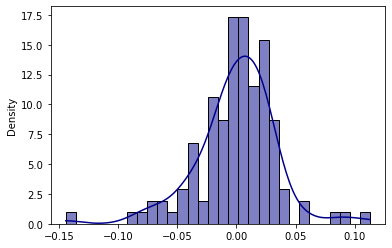

In [88]:
sns.histplot(residuals, color='darkblue', bins=30,
             kde=True, stat="density", linewidth=1)

In [91]:
# Shapiro normality test
stat, p = shapiro(residuals)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')
    

Statistics=0.939, p=0.000
Sample does not look Gaussian (reject H0)


In [92]:
#Mann-Whitney-Wilkoxon test
resid_set_1 = residuals[:int(len(residuals)/2)]
resid_set_2 = residuals[int(len(residuals)/2):]
stat, p = mannwhitneyu(resid_set_1, resid_set_2)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=1676.000, p=0.213


In [94]:
#Goldfeld-Quandt test (heteroscedasticity).
y = ms_final.Premium[1:]
print(statsmodels.stats.diagnostic.het_goldfeldquandt(y, ms_final[['Ambiguity', 'Volat_market']][1:]))


(3.897915490003494, 2.730785476841434e-07, 'increasing')


In [95]:
#Durbin-Watson test
stat = durbin_watson(residuals)
if not 1.5<=stat<=2.5:
    print('autocorrelation is problematic')
else:
    print('everything is ok')
print(stat)

everything is ok
1.9950150632462642


In [96]:
# VIF test
vif_data = pd.DataFrame()
vif_data["feature"] = ['Ambiguity', 'Volat_market']
vif_data["VIF"] = [variance_inflation_factor(ms_final[['Ambiguity', 'Volat_market']][1:].values, i) for i in range(len(['Ambiguity', 'Volat_market']))]
display(vif_data)

,feature,VIF
0,Ambiguity,1.024598
1,Volat_market,1.024598
